# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [1]:
!pip install tensorly

In [11]:
from torch.optim.optimizer import Optimizer
from tensorly.decomposition import tucker
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torch.optim import SGD
from tqdm import tqdm
import numpy as np
import tensorly
import torch
import time

## 0. Перепишем функции fold() и unfold() из tensorly под torch.

In [12]:
def reorder(indices, mode):
  
    indices = list(indices)
    element = indices.pop(mode)
    return ([element] + indices[::-1])

In [13]:
def unfold(tensor, mode=0):

    return tensor.permute(reorder(range(tensor.ndim), mode)).reshape((tensor.shape[mode], -1))

In [14]:
def fold(unfolded, mode, shape):

    unfolded_indices = reorder(range(len(shape)), mode)
    original_shape = [shape[i] for i in unfolded_indices]
    unfolded = unfolded.reshape(original_shape)

    folded_indices = list(range(len(shape)-1, 0, -1))
    folded_indices.insert(mode, 0)
    return unfolded.permute(folded_indices)

## 1. Метод для восстановления тензора по разложению.

In [15]:
def repair_tensor(core, factors):

    core_unfold = unfold(core, 0)
    kron_prod = factors[1]
    
    for factor in factors[2:]:
        kron_prod = torch.kron(factor, kron_prod)    
    
    data_shape = [factor.shape[0] for factor in factors]
    auxiliary = torch.matmul(core_unfold, torch.t(kron_prod))
    data_unfold = torch.matmul(factors[0], auxiliary)
    
    return fold(data_unfold, 0, data_shape)

## 2. Создание трёхмерного мерного тензора.

In [16]:
def get_tensor(size=(100,200,150), r=10):
    
    if type(r) == int:
        r = (r for i in len(size))
    
    elif type(r) == tuple or type(r) == list:
        pass
    
    else:
        raise RuntimeError(f"unexpected core's rang type: {type(r)};")
        
    core = torch.randint(low=0, high=10, size=r, dtype=torch.double)
    
    factors = []
    
    for i in range(len(size)):
        
        size_factor = (size[i], r[i])
        factor = torch.randint(low=0, high=2, size=size_factor, 
                               dtype=torch.double)
        
        factors.append(factor)
        
    factors = np.array(factors)
    data = repair_tensor(core, factors)
  
    return data, factors, core

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [17]:
data, U, G = get_tensor(r=(10, 20, 30))
data.shape, [u.shape for u in U], G.shape

C:\Users\Michail\AppData\Local\Temp\ipykernel_17996\3928706542.py:24: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  factors = np.array(factors)
C:\Users\Michail\AppData\Local\Temp\ipykernel_17996\3928706542.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  factors = np.array(factors)


(torch.Size([100, 200, 150]),
 [torch.Size([100, 10]), torch.Size([200, 20]), torch.Size([150, 30])],
 torch.Size([10, 20, 30]))

## 3. Разложение библиотечным методом.

In [ ]:
core, factors = tucker(data.numpy(), (10, 20, 30))

In [ ]:
print(f'MSE for core: {np.mean((core - G.numpy()) ** 2)};')

In [ ]:
mse_fact = np.array([np.mean((factors[i] - U[i].numpy()) ** 2) for i in range(len(factors))])

print(f'MSE for factors: {mse_fact}')

## 4. Разложение градиентным методом. 

In [18]:
class DummieOptimizer(Optimizer):

    def __init__(self, params, lr=1e-5):
        
        defaults = dict(lr=lr)
        super(DummieOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        
        for group in self.param_groups:
            for param in group['params']:
                
                if param.grad is None:
                    continue
                
                param.data -= group['lr'] * param.grad.data

In [19]:
def perform_gradient_decomposition(data, core_size, data_size, optimizer='sgd'):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    core = torch.randint(low=0, high=2, size=core_size, dtype=torch.double,
                         requires_grad=True, device=device)

    factors = [torch.randint(low=0, high=2, size=(data_size[i], core_size[i]), 
                             dtype=torch.double, requires_grad=True, device=device)
               for i in range(len(data_size))]
  
    iter_amount, criterion = int(1e3), 1e-4
    losses, mse_loss = [], MSELoss()

    opt = SGD([core] + factors, lr=1e-5)

    if optimizer == 'dummie':
        opt = DummieOptimizer([core] + factors, lr=1e-5)

    for i in tqdm(range(iter_amount)):

        opt.zero_grad()

        loss = mse_loss(repair_tensor(core, factors), data)
        losses.append(loss.item())

        if losses[-1] < criterion:
            break

        loss.backward()
        opt.step()

    return core, factors, losses

In [20]:
core_size = (10, 20, 30)
data_size = (100, 200, 150)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = torch.randint(low=0, high=10, size=data_size, dtype=torch.double,
                     device=device)

core_sgd, factors_sgd, loss_sgd = perform_gradient_decomposition(data, core_size, 
                                                                 data_size, 'sgd')
core_dum, factors_dum, loss_dum = perform_gradient_decomposition(data, core_size, 
                                                                 data_size, 'dummie')

 60%|███████████████████████████████████████████████                                | 596/1000 [02:37<01:46,  3.79it/s]


KeyboardInterrupt: 

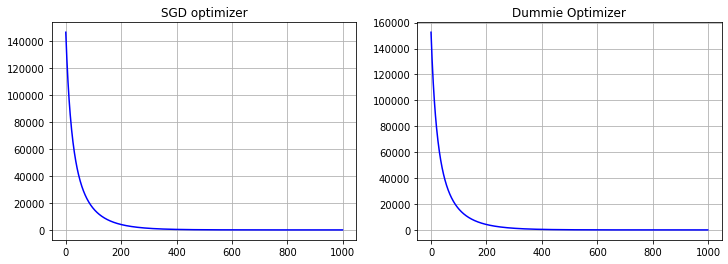

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('SGD optimizer')
ax2.set_title('Dummie Optimizer')

ax1.plot(loss_sgd, c='b')
ax2.plot(loss_dum, c='b')

ax1.grid()
ax2.grid()

plt.show()

## 5. Сравнения.

In [107]:
print(f'SGD loss: {loss_sgd[-1]};', 
      f'Dummie loss: {loss_dum[-1]};',
      sep='\n')

SGD loss: 60.535413239643496;
Dummie loss: 61.96952379542741;


In [108]:
data_sgd = repair_tensor(core_sgd, factors_sgd)
data_dum = repair_tensor(core_dum, factors_dum)

print(f'SGD error: {torch.mean((data - data_sgd) ** 2)};')
print(f'Dummie error: {torch.mean((data - data_dum) ** 2)};')

SGD error: 60.52988532259447;
Dummie error: 61.96295862729082;


In [ ]:
time_sgd = []
time_dum = []

for i in range(10):

    core_size = (10, 20, 30)
    data_size = (100, 200, 150)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = torch.randint(low=0, high=10, size=data_size, dtype=torch.double,
                         device=device)

    t = time.time()
    _, _, loss_sgd = perform_gradient_decomposition(data, core_size, 
                                                    data_size, 'sgd')
    time_sgd.append(time.time() - t)

    t = time.time()
    _, _, loss_dum = perform_gradient_decomposition(data, core_size, 
                                                    data_size, 'dummie')
    time_dum.append(time.time() - t)
    
print(f'Time SGD: {sum(time_sgd) / len(time_sgd)}')
print(f'Time SGD: {sum(time_dum) / len(time_dum)}')

 21%|██        | 208/1000 [00:06<00:25, 30.84it/s]